In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

# Imports

In [2]:
import numpy as np
from tqdm import tqdm

# train
device = torch.device('cuda:0')

def test(model, data_loader, split, dataset_name):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
            
            targets = targets.detach().cpu()
            outputs = outputs.detach().cpu()
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(dataset_name, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


def platt_logits(preds, labels, max_iters=100, lr=0.01, epsilon=0.005):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(preds),
                                            torch.from_numpy(labels).long()) 
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             pin_memory=True)
    nll_criterion = nn.CrossEntropyLoss().cuda()

    T = nn.Parameter(torch.Tensor([1.]).cuda())
    optimizer = optim.SGD([T], lr=lr)
    for iter in tqdm(range(max_iters)):
        T_old = T.item()
        for x, targets in dataloader:
            optimizer.zero_grad()
            x = x.cuda()
            x.requires_grad = True
            out = x/T
            loss = nll_criterion(out, targets.long().cuda())
            loss.backward()
            optimizer.step()
        if abs(T_old - T.item()) < epsilon:
            break
    return T.item() 


# Load and eval a trained model

In [3]:
import PIL

UNIFY_DATASET_NAMES = ['organamnist', 'bloodmnist']

# tissuemnist, organamnist, pathmnist, bloodmnist
dataset_name = 'tissuemnist'
use_plat = True

unify_test_and_val = True if dataset_name in UNIFY_DATASET_NAMES else False
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[dataset_name]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
# preprocessing
# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

data_transform = transforms.Compose(
    [transforms.Resize((224, 224), interpolation=PIL.Image.NEAREST), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

val_dataset = DataClass(split='val', transform=data_transform, download=download, as_rgb=True)
test_dataset = DataClass(split='test', transform=data_transform, download=download, as_rgb=True)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/royhirsch/.medmnist/tissuemnist.npz
Using downloaded and verified file: /home/royhirsch/.medmnist/tissuemnist.npz


In [4]:
from torchvision.models import resnet18, resnet50

device = torch.device('cuda:0')

num_classes = len(np.unique(val_dataset.labels))
model = resnet50(pretrained=False, num_classes=num_classes)

model.load_state_dict(torch.load(f'/home/royhirsch/conformal/notebooks/medmnist/{dataset_name}/resnet50_224_1.pth')['net'])
model = model.to(device)
model = model.eval()

# print('==> Evaluating ...')
# test(model, val_loader, 'val', dataset_name)
# test(model, test_loader, 'test', dataset_name)

/home/royhirsch/miniconda3/envs/conf/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/royhirsch/miniconda3/envs/conf/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
import sys
sys.path.append('/home/royhirsch/conformal')
from extract import get_embeds_logits
from data import ScoresDataset
from conformal_baselines import naive, aps, raps, my_aps, calc_conformal_mets

val_embeds, val_preds, val_labels = get_embeds_logits(model, val_loader, device)
test_embeds, test_preds, test_labels = get_embeds_logits(model, test_loader, device)
print(val_embeds.shape, test_embeds.shape)

100%|██████████| 185/185 [01:30<00:00,  2.04it/s]


(23640, 2048) (47280, 2048)


In [6]:
from scipy.special import softmax
import torch

if unify_test_and_val:
    embeds = np.concatenate([val_embeds, test_embeds])
    preds = np.concatenate([val_preds, test_preds])
    labels = np.squeeze(np.concatenate([val_labels, test_labels]))
else:
    embeds = test_embeds
    preds = test_preds
    labels = np.squeeze(test_labels)

if use_plat:
    t = platt_logits(preds, labels, 100)
else:
    t = 1

probs = softmax(preds / t, 1)
print(embeds.shape, probs.shape, labels.shape, t)

  1%|          | 1/100 [00:01<02:22,  1.44s/it]

(47280, 2048) (47280, 8) (47280,) 1.218401312828064


In [7]:
ds = ScoresDataset(torch.tensor(embeds),
                   torch.tensor(probs),
                   torch.tensor(labels),
                   torch.tensor(np.zeros_like(labels)))
dl = data.DataLoader(ds)

n_calib = 500
alpha = 0.1

mets = {}

conf_sets, conf_labels = naive(dl, None, n_calib, alpha)
mets['naive'] = calc_conformal_mets(conf_sets, conf_labels)

conf_sets, conf_labels = aps(dl, None, n_calib, alpha)
mets['aps'] = calc_conformal_mets(conf_sets, conf_labels)

conf_sets, conf_labels = raps(dl, None, n_calib, alpha)
mets['raps'] = calc_conformal_mets(conf_sets, conf_labels)

for k, v in mets.items():
    print(k)
    for kk, vv in v.items():
        print(f'{kk}: {vv:.3f}')
    print('\n')


naive
set_size_mean: 2.154
set_size_std: 1.030
acc_per_label_mean: 0.874
acc: 0.913


aps
set_size_mean: 3.729
set_size_std: 1.864
acc_per_label_mean: 0.933
acc: 0.918


raps
set_size_mean: 2.314
set_size_std: 1.249
acc_per_label_mean: 0.875
acc: 0.900




# Parametric

In [8]:
import os
import sys
sys.path.append('/home/royhirsch/conformal')

from ml_collections import config_dict
import logging
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import utils as utils
from experiment import get_config, run_experiment

config = get_config()
config.alpha = 0.1
# config.lr = 1e-3
# config.wd = 1e-4
config.num_epochs = 60
config.hidden_dim = 32
utils.seed_everything(config.seed)
utils.create_logger(config.exp_dir, False)
outs = run_experiment(config)


INFO - 10/02/23 12:07:44 - 0:00:00 - Created main log at /home/royhirsch/conformal/exps/temp1/net_launcher_log.log
INFO - 10/02/23 12:07:44 - 0:00:00 - Config:
INFO - 10/02/23 12:07:44 - 0:00:00 - alpha: 0.1
INFO - 10/02/23 12:07:44 - 0:00:00 - batch_size: 128
INFO - 10/02/23 12:07:44 - 0:00:00 - comments: 
INFO - 10/02/23 12:07:44 - 0:00:00 - conformal_module_name: aps
INFO - 10/02/23 12:07:44 - 0:00:00 - criteria_name: mse
INFO - 10/02/23 12:07:44 - 0:00:00 - device: cuda:0
INFO - 10/02/23 12:07:44 - 0:00:00 - drop_rate: 0.0
INFO - 10/02/23 12:07:44 - 0:00:00 - dump_log: False
INFO - 10/02/23 12:07:44 - 0:00:00 - exp_dir: /home/royhirsch/conformal/exps/temp1
INFO - 10/02/23 12:07:44 - 0:00:00 - file_name: /home/royhirsch/conformal/data/embeds_n_logits/aug/medmnist/tissuemnist_test.pickle
INFO - 10/02/23 12:07:44 - 0:00:00 - gpu_num: 0
INFO - 10/02/23 12:07:44 - 0:00:00 - hidden_dim: 32
INFO - 10/02/23 12:07:44 - 0:00:00 - input_dim: 2048
INFO - 10/02/23 12:07:44 - 0:00:00 - label_tra

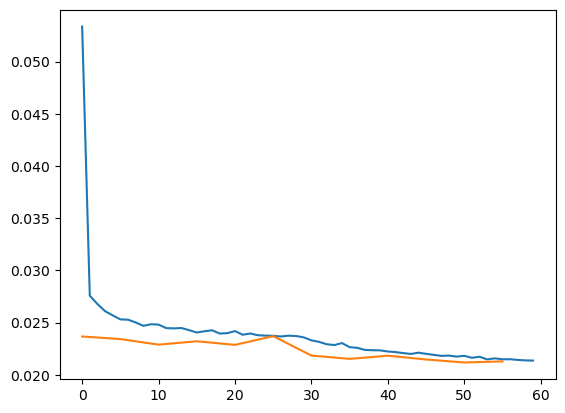

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.plot(outs['history']['loss'], label='loss')
plt.plot(np.arange(0, len(outs['history']['loss']), config.val_interval),
         outs['history']['val_loss'], label='val_loss')

In [10]:
# calibrate with the test set
pred_scores = outs['test_out']['pred_scores']
true_scores = outs['test_out']['true_scores']

diff = true_scores - pred_scores
alpha = config.alpha
n = len(diff)
qhat = np.quantile(
    diff, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")
print(qhat)

0.20377791


/tmp/ipykernel_83211/1608531041.py:8: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(


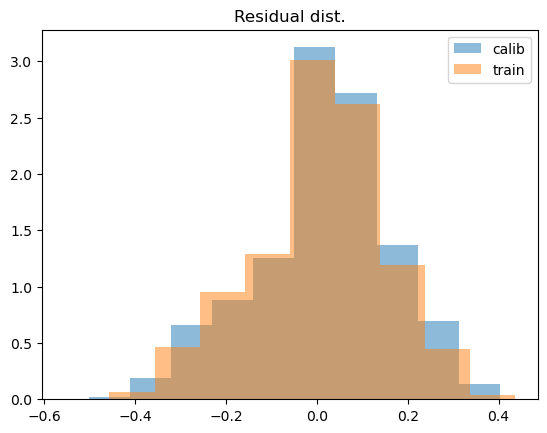

In [11]:
train_pred_scores = outs['train_out']['pred_scores']
train_true_scores = outs['train_out']['true_scores']
train_diff = train_true_scores - train_pred_scores

plt.hist(diff, label='calib', alpha=0.5, density=True)
plt.hist(train_diff, label='train', alpha=0.5, density=True)
plt.title('Residual dist.')
plt.legend()

In [12]:
# update the validation scores
pred_scores = outs['val_out']['pred_scores']
true_scores = outs['val_out']['true_scores']
cls_probs = outs['val_out']['cls_probs']
cls_labels = outs['val_out']['cls_labels']

clip_value = np.max(outs['train_out']['true_scores'])
if config.use_score_clipping:
    pred_scores[pred_scores > clip_value] = clip_value

modified_scores = pred_scores + qhat

inds = np.where(modified_scores >= 1.)
if len(inds[0]):
    print(len(inds[0]) / len(cls_labels))
    modified_scores[inds[0]] = clip_value

from conformal import APS

conformal_module = APS()
sets = conformal_module.get_sets(
    modified_scores,
    cls_probs)
mets = conformal_module.get_conformal_mets(sets, cls_labels)
print(mets)


0.38142857142857145
{'sets': 2.3414285714285716, 'acc': 0.5888571428571429}


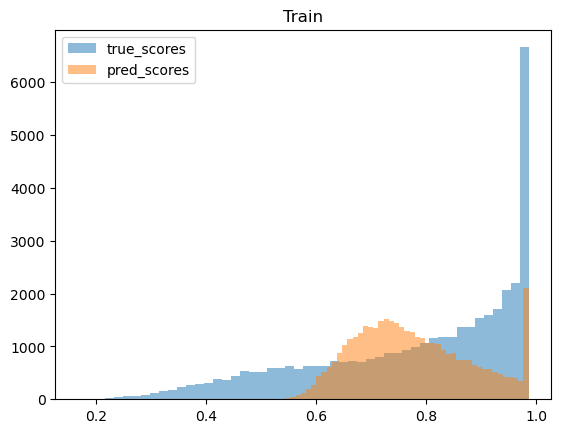

In [13]:
nbins = 50
pred_scores = outs['train_out']['pred_scores']
true_scores = outs['train_out']['true_scores']

plt.title('Train')
plt.hist(true_scores, bins=nbins, label='true_scores', alpha=0.5)
plt.hist(pred_scores, bins=nbins, label='pred_scores', alpha=0.5)
plt.legend()

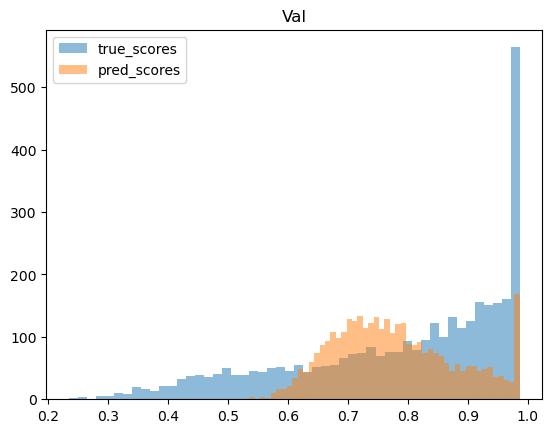

In [14]:
nbins = 50
pred_scores = outs['val_out']['pred_scores']
true_scores = outs['val_out']['true_scores']

plt.title('Val')
plt.hist(true_scores, bins=nbins, label='true_scores', alpha=0.5)
plt.hist(pred_scores, bins=nbins, label='pred_scores', alpha=0.5)
plt.legend()